In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
matplotlib.rc('font', family='arial') 
import matplotlib.pyplot as plt
import numpy as np
from h5py import File
from fish.image.zds import ZDS
from fish.image.vol import InterpArray
from os.path import exists
import dask.array as da
from dask.distributed import Client
from scipy.ndimage.filters import median_filter

import flika as flk
flk.start_flika()
from flika.window import Window as flw

def axs_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
def get_klab_dataset(path):
    from glob import glob
    from fish.util.fileio import to_dask
    files = sorted(glob(path + 'TM*/*/*CM0*'))
    dsk = to_dask(files).squeeze().transpose(0,3,2,1)
    
    return dsk

Starting flika
Starting flika inside IPython


In [2]:
%%bash
cat /nrs/keller/ForDavis/Dme_L1_57C10GCaMP641-54B03TDT_0_20130912_145536.corrected/SPM00/TM00000/ch0.xml

<?xml version="1.0" encoding="utf-8"?>
<push_config version="1.0">
<info software_version="1.7.073" />
<info data_header="Dme_L1_57C10GCaMP641-54B03TDT_0" />
<info output_root="" />
<info specimen_name="Specimen 1" />
<info timestamp="2:55:39.563 PM 9/12/2013" />
<info time_point="0" />
<info specimen_XYZT="X=3324.000_Y=1810.000_Z=-85.000_T=-130.0" />
<info specimen_drift="N/A" />
<info angle="-130.0" />
<info camera_index="2" />
<info camera_type="C11440-22C,C11440-22C" />
<info camera_roi="369_1784_605_1468,401_1816_605_1468" />
<info time_step="1" />
<info wavelength="488" />
<info illumination_arms="1 & 2" />
<info illumination_filter="BP488/10" />
<info laser_power="13.00" />
<info exposure_time="8.0" />
<info detection_filter="BP525/50" />
<info dimensions="864x1412x40,864x1412x40" />
<info z_step="5.687" />
<info planes="0-39,0-39" />
<info detection_objective="Nikon 16x/0.80,Nikon 16x/0.80" />
<info backgound_subtraction="n,n" />
<info SI="n" />
<info experiment_notes="" />
<in

In [3]:
data = get_klab_dataset('/nrs/keller/ForDavis/Dme_L1_57C10GCaMP641-54B03TDT_0_20130912_145536.corrected/SPM00/')
data = data[750:]

In [4]:
reg_dir = '/groups/ahrens/ahrenslab/davis/tmp/Dme_L1_57C10GCaMP641-54B03TDT_0/'
if not exists(reg_dir):
    from os import makedirs
    makedirs(reg_dir)

In [5]:
# 8 ms exposure * 40 planes
fs_im = (.08 * 40)

In [6]:
data.shape

(1051, 40, 1386, 784)

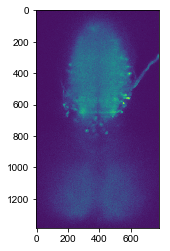

In [7]:
roi = slice(None), slice(20,21), slice(None), slice(None)
crop=slice(None), slice(None), slice(None), slice(None)
sample = data[roi][-1].compute(scheduler='threads').squeeze()
plt.imshow(sample)

In [77]:
window_seconds = 90
window_frames = int(window_seconds * fs_im)
camera_baseline = 80
perc = 20

def mybl(v):
    from fish.image.vol import baseline
    window = window_frames
    percentile = perc
    downsample = 1;
    return baseline(v, window, percentile, downsample, axis=0).astype('float32')

def mydff(v):
    return (v / mybl(v).clip(1,None))

def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0] 
    im_ = im
    if im.dtype == 'float16':
        im_ = im.astype('float32')
    return shift(im_, (0,0, *shifts[t]), order=1, cval=100).astype(im.dtype)


In [28]:
from fish.util.distributed import get_jobqueue_cluster
cluster = get_jobqueue_cluster()
client = Client(cluster)
client

Client Scheduler: tcp://10.36.111.12:39188 Dashboard: http://10.36.111.12:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [29]:
data_filt = data[roi].astype('float32')
rechunked = data_filt.rechunk((-1, 'auto', 'auto','auto'))

In [30]:
cluster.start_workers(100)
sample_t = data_filt.compute().squeeze()
cluster.stop_all_jobs()

In [39]:
win = flw(sample_t)

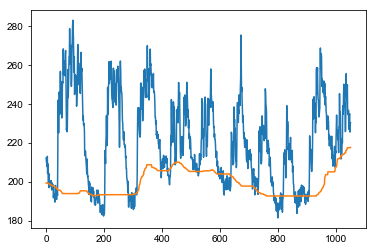

In [87]:
trace = win.rois[0].getTrace()
plt.plot(trace)
plt.plot(mybl(trace))

In [ ]:
from fish.util.distributed import get_downsampled_baseline
from os.path import exists
from os import remove
ds_factors = [48, 60, 72, 84, 96]
window = window_frames

bl_fnames = [reg_dir + f'baseline_ds{ds}.h5' for ds in ds_factors]
[remove(b) for b in bl_fnames if exists(b)]
compute_baselines = True

if compute_baselines:
    params = [get_downsampled_baseline(data_filt, factor=ds, window=window, perc=perc) for ds in ds_factors]
    cluster.start_workers(400)

    for ind, p in enumerate(params):
        fn = bl_fnames[ind]
        with File(fn, mode='a') as fh:
            try:
                fh['keyframes'] = p[0]
            except:
                fh['keyframes'][()] = p[0]
            dsb_ = p[1].compute()
            try:
                fh['baseline'][(slice(None), *roi[1:])] = dsb_
            except:
                fh.create_dataset('baseline', (len(p[0]), *data.shape[1:]))
                fh['baseline'][(slice(None), *roi[1:])] = dsb_

cluster.stop_all_jobs()

In [ ]:
# make some baselines 

In [ ]:
cluster.start_workers(100)
errs = [] 
blfull_ = (rechunked[crop] - camera_baseline).map_blocks(mybl, dtype='float32').squeeze().compute()

for bl_fname in bl_fnames:
    bl_h5 = da.from_array(File(bl_fname, libver='latest', mode='r')['baseline'], chunks=data.chunksize).astype('float32')
    kf = File(bl_fname, mode='r')['keyframes'][:]
    dsb = InterpArray(kf, bl_h5, full_shape=data.shape, interpolation_axis=0)[roi].astype('float32')        
    
    blds_ = (dsb[crop] - camera_baseline).squeeze().compute()
    err = ((blds_ / blfull_) - 1)
    
    result = err.mean(0), err.max(0)
    errs.append(result)
    
cluster.stop_all_jobs()
errs = np.array(errs)

In [ ]:
flw(blfull_)

In [ ]:
flw(np.concatenate((blfull_, blds_), axis=1))

In [ ]:
1 + 1

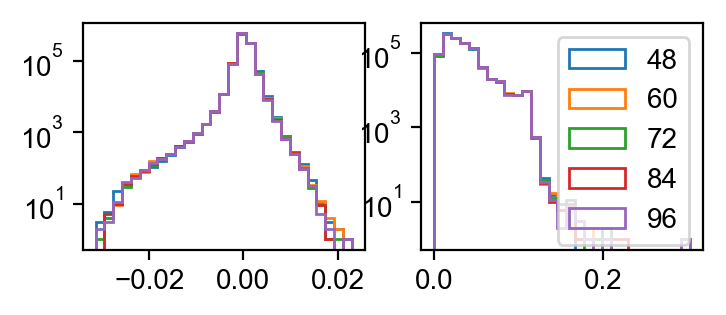

In [93]:
nbins = 30
bins_mean = np.linspace(errs[:,0].ravel().min(), errs[:,0].ravel().max(), nbins)
bins_max = np.linspace(np.abs(errs[:,1]).ravel().min(), np.abs(errs[:,1]).ravel().max(), nbins)

fig, axs = plt.subplots(ncols=2, figsize=(4,1.5), dpi=200)

[axs[0].hist(err[0].ravel(), bins=bins_mean, histtype='step') for err in errs];
[axs[1].hist(np.abs(err[1]).ravel(), bins=bins_max, histtype='step', label=ds_factors[ind]) for ind, err in enumerate(errs)];
#axs[0].set_xlim(-.02,.02)
axs[1].legend()
[ax.semilogy() for ax in axs]
plt.savefig('/groups/ahrens/ahrenslab/davis/thesis/baseline_error_klab_plots.pdf')

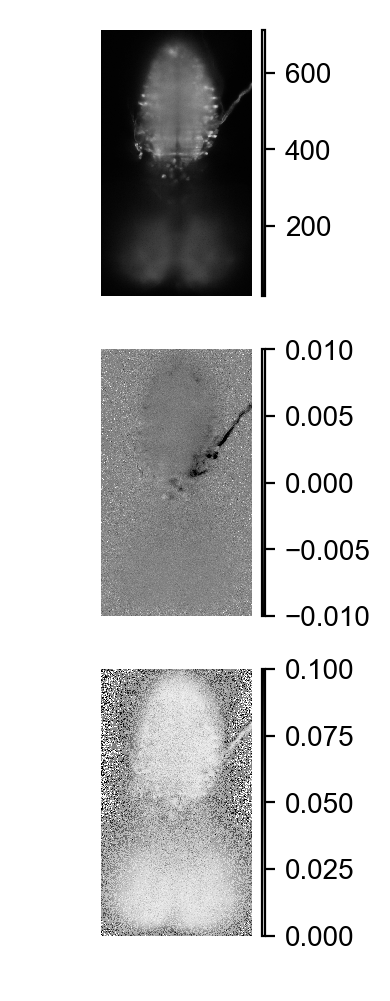

In [91]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(figsize=(4,6),nrows=3, dpi=200)
axs[0].imshow(blfull_[0], cmap='gray')
axs[1].imshow(errs[-1,0], cmap='gray', clim=(-.01, .01))
axs[2].imshow(errs[-1,1], cmap='gray_r', clim=(0,.1))

for ax in axs:
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(ax.images[0], cax=cax)
plt.savefig('/groups/ahrens/ahrenslab/davis/thesis/baseline_error_klab_images.pdf')

In [92]:
1 + 1

2

In [26]:
def colorize_bins(bins, patches, cmap):
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cmap(c))


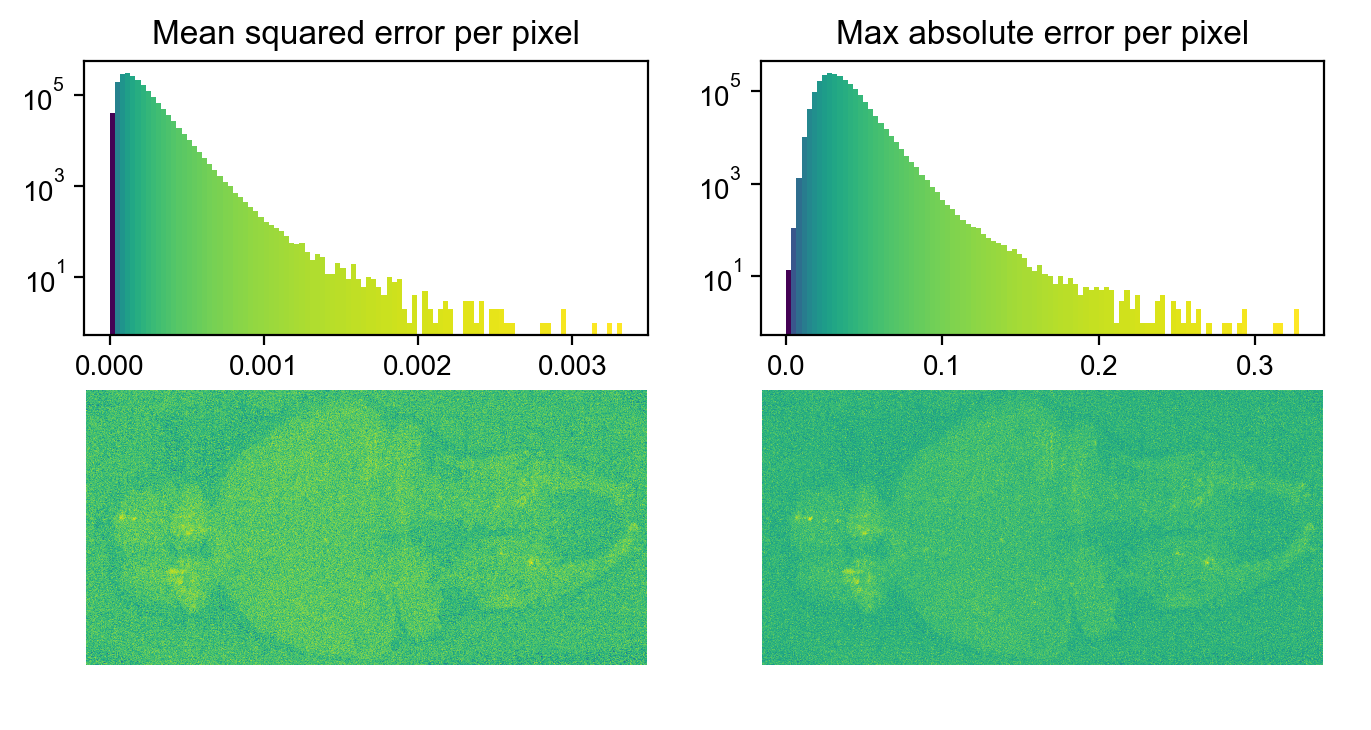

In [27]:
from matplotlib import cm
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(8,4), dpi=200)

axs[1,0].imshow(np.log(mse_result), cmap='viridis')
axs[1,0].axis('off')

axs[1,1].imshow(np.log(max_err_result), cmap='viridis')
axs[1,1].axis('off')

axs[0,0].title.set_text('Mean squared error per pixel')
_, bins, patches = axs[0,0].hist(mse_result.ravel(), 100);
colorize_bins(np.log(bins), patches, cm.viridis)
axs[0,0].semilogy();

axs[0,1].title.set_text('Max absolute error per pixel')
_, bins, patches = axs[0,1].hist(max_err_result.ravel(), 100);
colorize_bins(np.log(bins), patches, cm.viridis)
axs[0,1].semilogy();
